In [1]:
import gurobipy as gp
from gurobipy import Model, GRB, quicksum
import random
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.colors import ListedColormap

### You need to get your own license file from Gurobi's website ! It is for single machine use only ! 

In [2]:
import os
import gurobipy as gp

# Set the GRB_LICENSE_FILE environment variable to the correct license file path
os.environ["GRB_LICENSE_FILE"] = "/Users/emrekuru/Developer/Production_Planning/gurobi.lic"

In [3]:
model = gp.Model("PaintingProcessOptimization")

Set parameter Username
Academic license - for non-commercial use only - expires 2025-11-11


In [4]:
# Parameters
num_parts = 10     # Number of parts
demand = {p: 50 for p in range(1, num_parts + 1)}  

color_cost = {
    'Red': 10,
    'Blue': 10,
    'Green': 10,
    'Yellow': 10,
    'Black': 10,
    "Pink": 10,
    "Purple": 10,
    }

parts_colors = {} 

group_length = 2

for i in range(1, num_parts + 1, group_length):
    color = random.choice(list(color_cost.keys()))
    while color in parts_colors.values():
        color = random.choice(list(color_cost.keys()))
        
    for j in range(group_length):
        parts_colors[i + j] = color

max_time_machine_A = (num_parts * max(demand.values())) / 2 + 100
max_time_machine_B =(num_parts * max(demand.values())) / 2 + 100

In [5]:
parts_colors

{1: 'Black',
 2: 'Black',
 3: 'Purple',
 4: 'Purple',
 5: 'Yellow',
 6: 'Yellow',
 7: 'Pink',
 8: 'Pink',
 9: 'Blue',
 10: 'Blue'}

In [6]:
machines = [1,2]
# Define continuous variables for start and end times of production for each part
start_times = model.addVars(range(1, num_parts + 1), vtype=GRB.CONTINUOUS, name="start_times")
end_times = model.addVars(range(1, num_parts + 1), vtype=GRB.CONTINUOUS, name="end_times")

# Define binary variable to indicate successor relationship for each machine
# successor[p, p_prime, m] = 1 if part p is the immediate predecessor of part p_prime on machine m
successor = model.addVars(range(1, num_parts + 1), range(1, num_parts + 1), machines, vtype=GRB.BINARY, name="successor")

# Define binary variable for color change costs on each machine
# color_change[p, p_prime, m] = 1 if there is a color change between part p and part p_prime on machine m
color_change = model.addVars(range(1, num_parts + 1), range(1, num_parts + 1), machines, vtype=GRB.BINARY, name="color_change")

# Define binary variables for machine assignments: machine_assignment[p, m] = 1 if part p is assigned to machine m
machine_assignment = model.addVars(range(1, num_parts + 1), machines, vtype=GRB.BINARY, name="machine_assignment")

In [7]:
model.setObjective(
    quicksum(
        color_cost[parts_colors[p]] * color_change[p, q, m]
        for p in range(1, num_parts + 1)
        for q in range(1, num_parts + 1)
        for m in machines
    ),
    GRB.MINIMIZE
)


In [8]:
big_M = 1e6

# Ensure each part has at most one immediate successor, with exactly one part having no successor (the end part) per machine
for p in range(1, num_parts + 1):
    for m in machines:
        model.addConstr(
            quicksum(successor[p, q, m] for q in range(1, num_parts + 1) if q != p) <= machine_assignment[p, m],
            name=f"Single_Successor_{p}_Machine_{m}"
        )

# Ensure each part has at most one immediate predecessor, with exactly one part having no predecessor (the start part) per machine
for q in range(1, num_parts + 1):
    for m in machines:
        model.addConstr(
            quicksum(successor[p, q, m] for p in range(1, num_parts + 1) if p != q) <= machine_assignment[q, m],
            name=f"Single_Predecessor_{q}_Machine_{m}"
        )

# Ensure exactly one part without a successor (the end part) per machine
for m in machines:
    model.addConstr(
        quicksum(quicksum(successor[p, q, m] for q in range(1, num_parts + 1) if q != p) for p in range(1, num_parts + 1)) 
        == quicksum(machine_assignment[p, m] for p in range(1, num_parts + 1)) - 1,
        name=f"Total_Successors_Machine_{m}"
    )

for p in range(1, num_parts + 1):
    for p_prime in range(1, num_parts + 1):
        if p != p_prime:
            for m in machines:
                # Ensure mutual exclusivity in order if both parts are assigned to machine m
                model.addConstr(
                    successor[p, p_prime, m] + successor[p_prime, p, m] <= 1,
                    name=f"Order_Exclusivity_{p}_{p_prime}_Machine_{m}"
                )
                
                # Ensure order variables are zero if either part is not assigned to machine m
                model.addConstr(
                    successor[p, p_prime, m] <= machine_assignment[p, m],
                    name=f"Order_Assignment_{p}_{p_prime}_Machine_{m}_1"
                )
                
                model.addConstr(
                    successor[p, p_prime, m] <= machine_assignment[p_prime, m],
                    name=f"Order_Assignment_{p}_{p_prime}_Machine_{m}_2"
                )

# Ensure color change costs are applied when there is a change in color between successive parts on the same machine
for p in range(1, num_parts + 1):
    for p_prime in range(1, num_parts + 1):
        if p != p_prime and parts_colors[p] != parts_colors[p_prime]:
            for m in machines:
                model.addConstr(
                    color_change[p_prime, p, m] >= successor[p, p_prime, m],
                    name=f"Color_Change_{p}_{p_prime}_Machine_{m}"
                )

# Demand fulfillment constraints to ensure each part meets its demand
for p in range(1, num_parts + 1):
    model.addConstr(
        (end_times[p] - start_times[p]) >= demand[p],
        name=f"Demand_Fulfillment_{p}"
    )

# Ensure each part is assigned to exactly one machine
for p in range(1, num_parts + 1):
    model.addConstr(
        quicksum(machine_assignment[p, m] for m in machines) == 1,
        name=f"Machine_Assignment_{p}"
    )

# Non-overlap constraint for parts on the same machine using big-M
for p in range(1, num_parts + 1):
    for p_prime in range(1, num_parts + 1):
        if p != p_prime:
            for m in machines:
                model.addConstr(
                    end_times[p] <= start_times[p_prime] + big_M * (1 - successor[p, p_prime, m]),
                    name=f"No_Overlap_Same_Machine_{p}_{p_prime}_Machine_{m}"
                )


# Ensure no end time goes past max_time_machine_A for all parts on machine A
for p in range(1, num_parts + 1):
    model.addConstr(
        end_times[p] <= max_time_machine_A + big_M * (1 - machine_assignment[p, 1]),
        name=f"Max_Time_Machine_A_{p}"
    )

# Ensure no end time goes past max_time_machine_A for all parts on machine A
for p in range(1, num_parts + 1):
    model.addConstr(
        end_times[p] <= max_time_machine_B + big_M * (1 - machine_assignment[p, 2]),
        name=f"Max_Time_Machine_A_{p}"
    )

# Cleaning Time Constraint
for p in range(1, num_parts + 1):
    for q in range(1, num_parts + 1):
        if p != q:
            for m in machines:
                model.addConstr(
                    end_times[p] + 1 <= start_times[q] + big_M * (1 - color_change[q, p, m]),
                    name=f"Cleaning_Time_{p}_{q}_Machine_{m}"
                )


In [9]:
# Set model parameters if necessary, e.g., setting the feasibility tolerance
model.setParam("IntFeasTol", 1e-9)
model.setParam("Threads", 16) 

# Optional: Currently going for the optimal solution
model.setParam("MIPGap", 0.15)       # Accept a solution within 1% of optimal

# Optimize the model
model.optimize()

Set parameter IntFeasTol to value 1e-09
Set parameter Threads to value 16
Set parameter MIPGap to value 0.15
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 24.1.0 24B83)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 16 threads

         Reduce the value of the Threads parameter to improve performance


Optimize a model with 1142 rows, 440 columns and 3160 nonzeros
Model fingerprint: 0xa039c267
Variable types: 20 continuous, 420 integer (420 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+06]
  Objective range  [1e+01, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+06]
Presolve removed 830 rows and 240 columns
Presolve time: 0.01s
Presolved: 312 rows, 200 columns, 1410 nonzeros
Variable types: 10 continuous, 190 integer (190 binary)

Root relaxation: objective 3.000000e+01, 95 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |    

In [10]:
# Check the number of quadratic constraints and non-zero quadratic terms in the objective
num_quadratic_constraints = model.getAttr("NumQConstrs")  # Number of quadratic constraints
num_quadratic_obj_terms = model.getAttr("NumQNZs")       # Number of non-zero quadratic terms in the objective

# Print the results to confirm linearity
print("Number of quadratic constraints:", num_quadratic_constraints)
print("Number of quadratic objective terms:", num_quadratic_obj_terms)

# Check if the model is MILP based on the absence of quadratic terms
is_milp = num_quadratic_constraints == 0 and num_quadratic_obj_terms == 0 and model.getAttr("IsMIP")
print("Model is MILP:", is_milp)


Number of quadratic constraints: 0
Number of quadratic objective terms: 0
Model is MILP: 1


In [11]:
start_times

{1: <gurobi.Var start_times[1] (value 199.0)>,
 2: <gurobi.Var start_times[2] (value 149.0)>,
 3: <gurobi.Var start_times[3] (value 50.0)>,
 4: <gurobi.Var start_times[4] (value 0.0)>,
 5: <gurobi.Var start_times[5] (value 250.0)>,
 6: <gurobi.Var start_times[6] (value 300.0)>,
 7: <gurobi.Var start_times[7] (value 101.0)>,
 8: <gurobi.Var start_times[8] (value 151.0)>,
 9: <gurobi.Var start_times[9] (value 50.0)>,
 10: <gurobi.Var start_times[10] (value 0.0)>}

In [12]:
end_times

{1: <gurobi.Var end_times[1] (value 249.0)>,
 2: <gurobi.Var end_times[2] (value 199.0)>,
 3: <gurobi.Var end_times[3] (value 100.0)>,
 4: <gurobi.Var end_times[4] (value 50.0)>,
 5: <gurobi.Var end_times[5] (value 300.0)>,
 6: <gurobi.Var end_times[6] (value 350.0)>,
 7: <gurobi.Var end_times[7] (value 151.0)>,
 8: <gurobi.Var end_times[8] (value 201.0)>,
 9: <gurobi.Var end_times[9] (value 100.0)>,
 10: <gurobi.Var end_times[10] (value 50.0)>}

In [13]:
# Check if the model is infeasible
if model.status == GRB.INFEASIBLE:
    print("Model is infeasible. Computing IIS...")
    model.computeIIS()
    model.write("model.ilp")
    
    # Print the constraints that are part of the IIS
    print("\nThe following constraints are part of the IIS:")
    for c in model.getConstrs():
        if c.IISConstr:
            print(f"{c.constrName}")

Optimal solution found:
Minimized Total Cost (Objective Value): 30.0


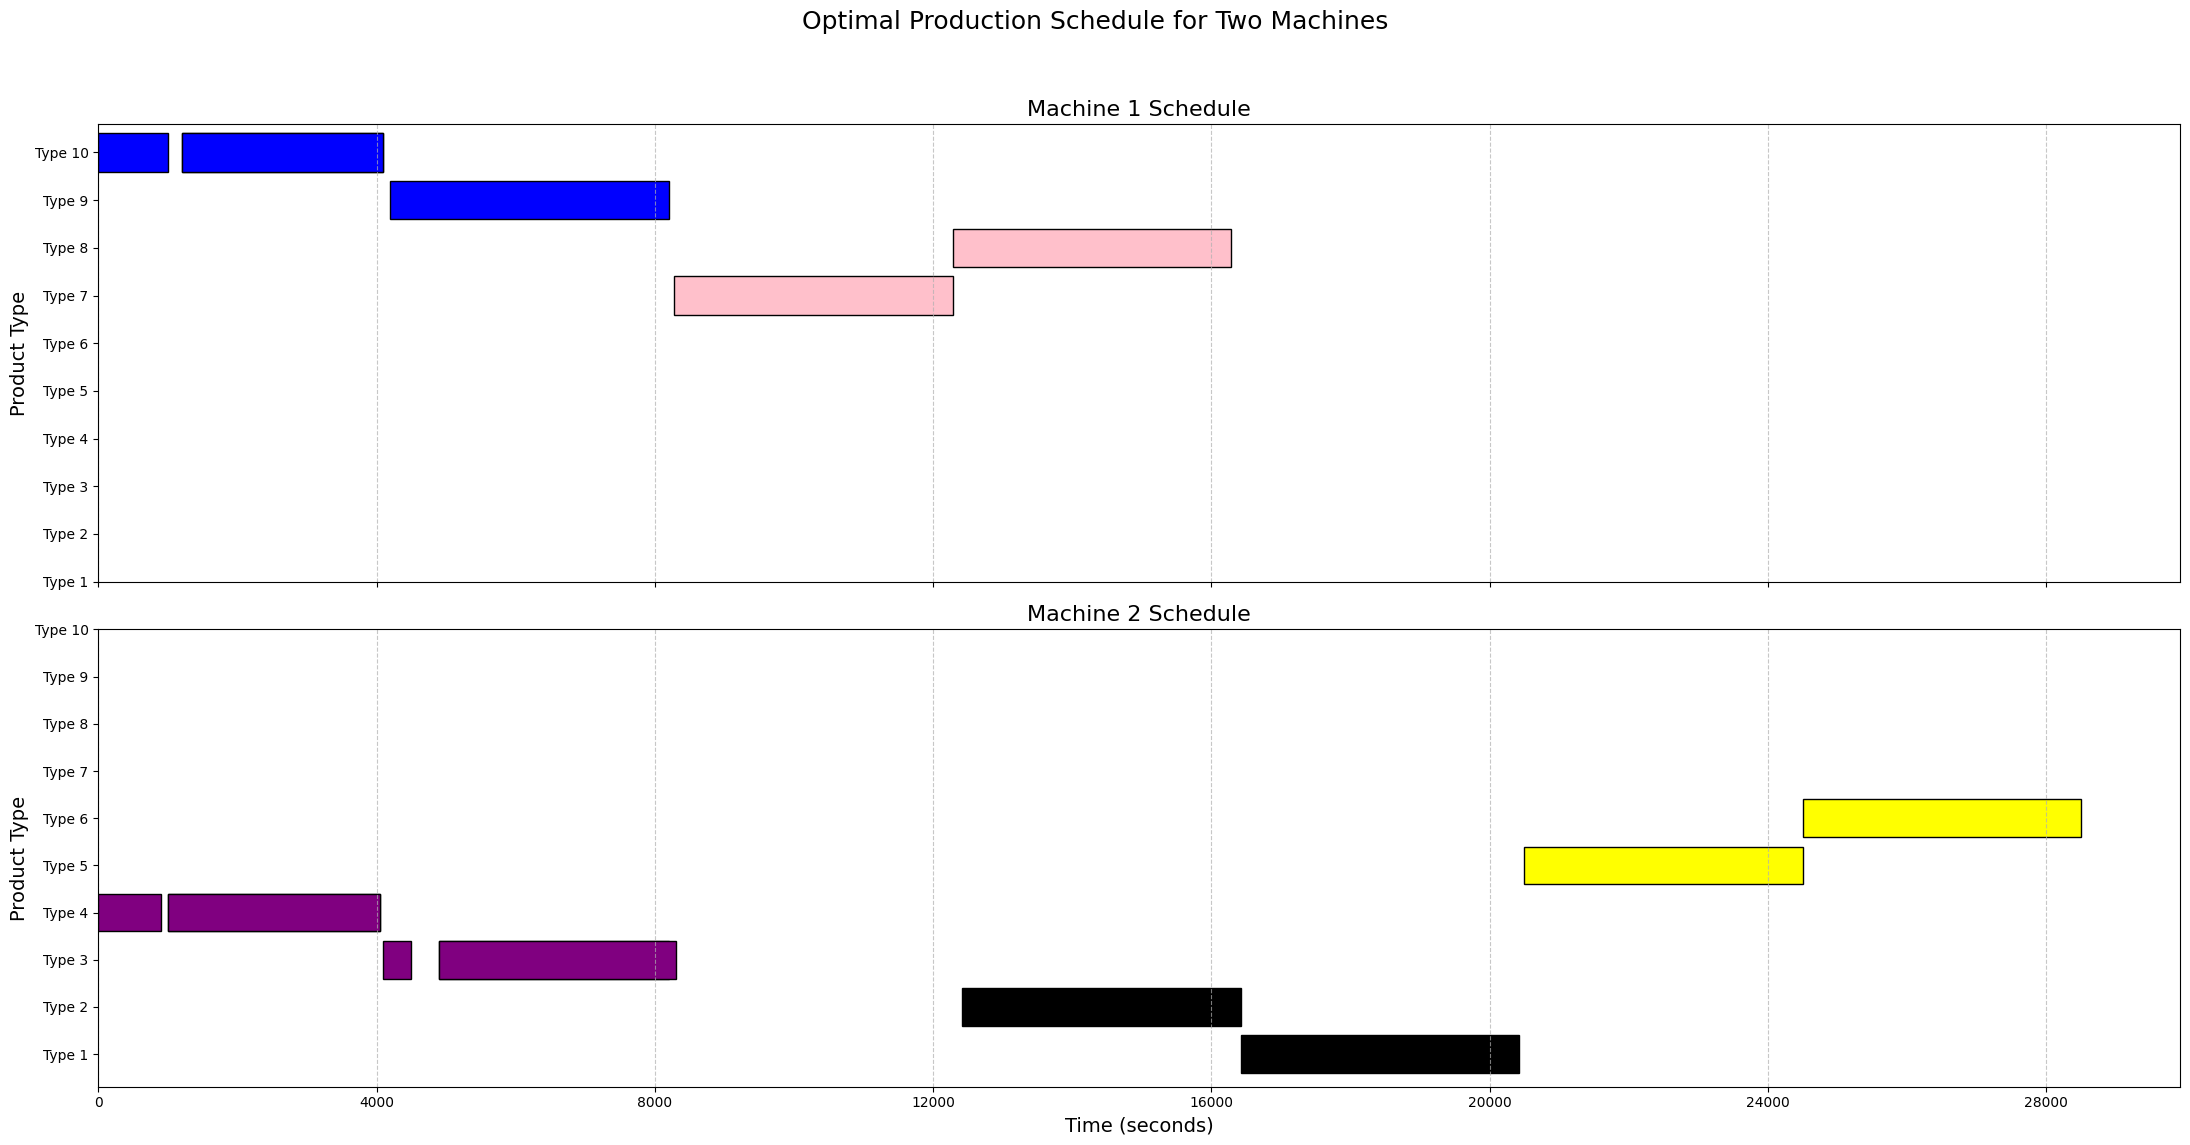

In [14]:
if model.status == GRB.OPTIMAL:
    print("Optimal solution found:")
    
    # Display objective function result
    minimized_cost = model.ObjVal
    print(f"Minimized Total Cost (Objective Value): {minimized_cost}")

    # Extract start and end times for each part assigned to each machine
    start_times_values = {p: start_times[p].X for p in range(1, num_parts + 1)}
    end_times_values = {p: end_times[p].X for p in range(1, num_parts + 1)}

    # Define unique break intervals for each machine (start, end, shift_amount)
    breaks = {
        1: [(1000, 1100, 100)],  # Break for Machine 1
        2: [(900, 950, 50), (4500, 4700, 200)]  # Breaks for Machine 2
    }

    # Plotting the Gantt chart with two subplots for Machine 1 and Machine 2
    fig, axs = plt.subplots(2, 1, figsize=(22, 12), sharex=True)
    
    # Define color mapping for the parts
    color_map = {
        'Red': 'red',
        'Blue': 'blue',
        'Green': 'green',
        'Yellow': 'yellow',
        'Black': 'black',
        'Purple': 'purple',
        'Orange': 'orange',
        'Pink': 'pink',
    }

    # Iterate through each machine and process parts in a sorted order
    for m in machines:
        ax = axs[m - 1]  # Subplot for each machine (Machine 1 and Machine 2)
        cumulative_shift = 0  # Track cumulative shifts for breaks

        # Sort parts by start time for consistent plotting
        sorted_parts = sorted([p for p in range(1, num_parts + 1) if machine_assignment[p, m].X > 0.5], 
                              key=lambda x: start_times_values[x])

        for p in sorted_parts:
            part_color = color_map[parts_colors[p]]
            start = start_times_values[p] * 80
            end = end_times_values[p] * 80
            shifted_start = start + cumulative_shift
            shifted_end = end + cumulative_shift

            # Check if the part needs to be split by any breaks
            for break_start, break_end, shift_amount in breaks[m]:
                if shifted_start < break_start < shifted_end:
                    # Plot the first segment before the break
                    ax.barh(p, break_start - shifted_start, left=shifted_start, color=part_color, edgecolor='black')

                    # Shift the second segment after the break
                    shifted_start = break_end + shift_amount
                    shifted_end += shift_amount
                    ax.barh(p, end - break_end, left=shifted_start, color=part_color, edgecolor='black')

                    # Update cumulative shift for the remaining parts
                    cumulative_shift += shift_amount
                    break  # Move to the next part after handling this break
                elif shifted_start >= break_end:
                    # Entire block is after the break; apply shift
                    shifted_start += shift_amount
                    shifted_end += shift_amount

            # Plot the adjusted (shifted) part
            ax.barh(p, shifted_end - shifted_start, left=shifted_start, color=part_color, edgecolor='black')

        # Customize each subplot
        ax.set_title(f"Machine {m} Schedule", fontsize=16)
        ax.set_ylabel("Product Type", fontsize=14)
        ax.set_yticks(range(1, num_parts + 1))
        ax.set_yticklabels([f'Type {i}' for i in range(1, num_parts + 1)])
        ax.grid(axis='x', linestyle='--', alpha=0.7)
    
    # Set common labels
    plt.xlabel("Time (seconds)", fontsize=14)
    plt.xticks(np.arange(0, (max(end_times_values.values()) + 1) * 80, 80 * max(demand.values())))  # Adjust x-tick intervals for seconds
    
    fig.suptitle("Optimal Production Schedule for Two Machines", fontsize=18)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout for title space

    # Save the plot as an image file
    plt.savefig("optimal_production_schedule.png")
else:
    print("No optimal solution found.")
